In [1]:
import femm
import time
import os
import numpy as np
import cmath
import pandas as pd 
from ipywidgets import IntProgress
from IPython.display import display
from scipy import fftpack
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
femm.openfemm()
femm.opendocument("femm/rogowski_simulation.fem");
femm.mi_saveas("femm/temp.fem")
femm.mi_seteditmode("group")
vr=[];
f=[];

units = "millimeters"
stype = 'planar'
precision = 10**-8
depth = 1
minangle = 30
acsolver = 0 # 0 to successive approximation or 1 to Newton  

init = 0
final = 2

progress = IntProgress(min=init, max=final, description='Simulation:') # instantiate the bar
display(progress) # display the bar

init_time = time.time()

for n in range(init,final): 
    if n == 0:
        n=0.00001
        
    freq = 1000*n
    f.append(freq)
    femm.mi_probdef(freq,units,stype,precision,depth,minangle,(acsolver))
    femm.mi_analyze()
    femm.mi_loadsolution()
    femm.mo_groupselectblock(1)
    v=femm.mo_getcircuitproperties("Ir")
    vr.append(v[1]) # get the voltage drop of Ir
    progress.value = n+1
femm.closefemm()

print('Time: ' + str(time.time() - init_time) + 's')

IntProgress(value=0, description='Simulation:', max=2)

Time: 18.27676010131836s


Text(0.5, 0, 'Frequency [Hz]')

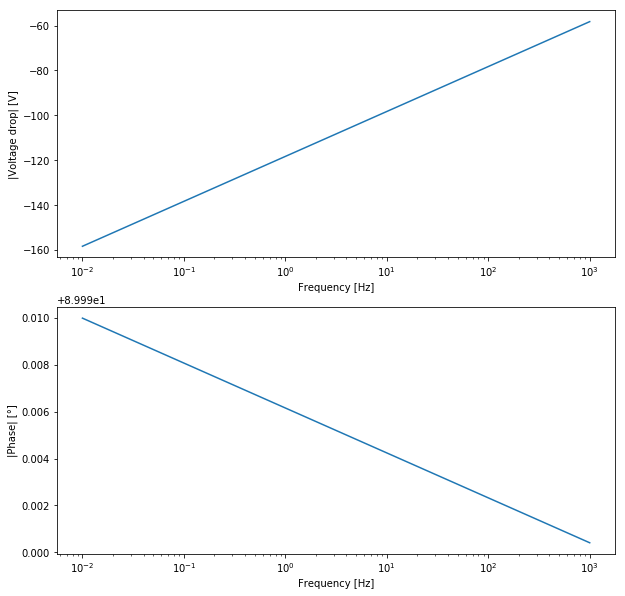

In [4]:
# Plot of Rogowski coil frequency response 
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax[0].semilogx(f,20*np.log10(np.abs(vr)/100))
ax[0].set_ylabel('|Voltage drop| [V]')
ax[0].set_xlabel('Frequency [Hz]')

ax[1].semilogx(f,np.angle(vr)*180/np.pi)
ax[1].set_ylabel('|Phase| [°]')
ax[1].set_xlabel('Frequency [Hz]')

In [5]:
# gain of Rg Coil
gain = np.abs(vr[-1])/(100*f[-1])

FFT and IFFT

In [6]:
# read file
file_data = pd.read_csv('../../../../../../vibration-analysis/datasets/MotorDesbalanceado.csv')
    
# get set of data from .csv file
data = 330*file_data['Amperimeter']
len_data = len(data)
   
init = 0.5
final = 0.55

# sample Rate in Hz
f_s = 10000

data_plot = data[int(init*len_data+1):int(final*len_data)]
fft_data = fftpack.fft(data_plot)
amplitude = np.abs(fft_data)
phase = np.angle(fft_data)
freqs = fftpack.fftfreq(len(data_plot)) * f_s

In [7]:
# Calculates the Rogowski voltage from the product between Rogowski coil frequency response and 
# the currente imported from another sensor
Ampl = []
Phs = []
polar = []

for n in range(0, len(freqs)):
    Ampl.append(amplitude[n]*gain*freqs[n])
    Phs.append(phase[n]*(180/np.pi) + 90)
    polar.append(cmath.rect(Ampl[n], Phs[n]))

C:\Users\Gpiaia\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gpiaia\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Frequency [Hz]')

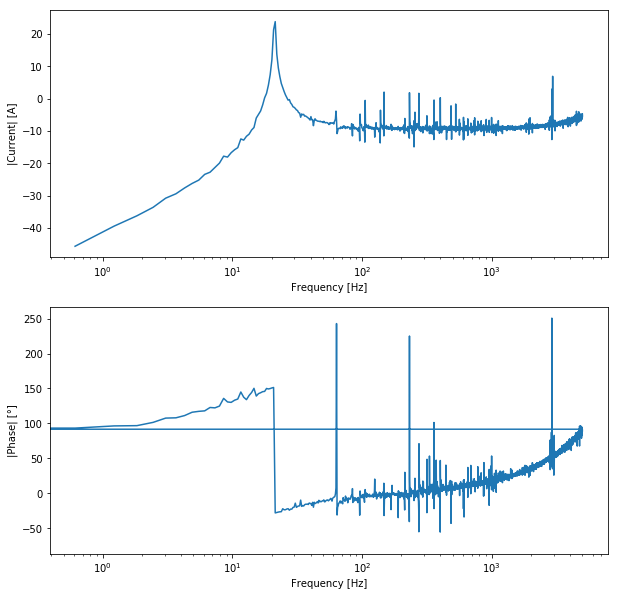

In [8]:
# Rogowski voltage Frequency response of a real current
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax[0].semilogx(freqs,20*np.log10(Ampl))
ax[0].set_ylabel('|Current| [A]')
ax[0].set_xlabel('Frequency [Hz]')

ax[1].semilogx(freqs,Phs)
ax[1].set_ylabel('|Phase| [°]')
ax[1].set_xlabel('Frequency [Hz]')

C:\Users\Gpiaia\Anaconda3.1\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(12000, 14000)

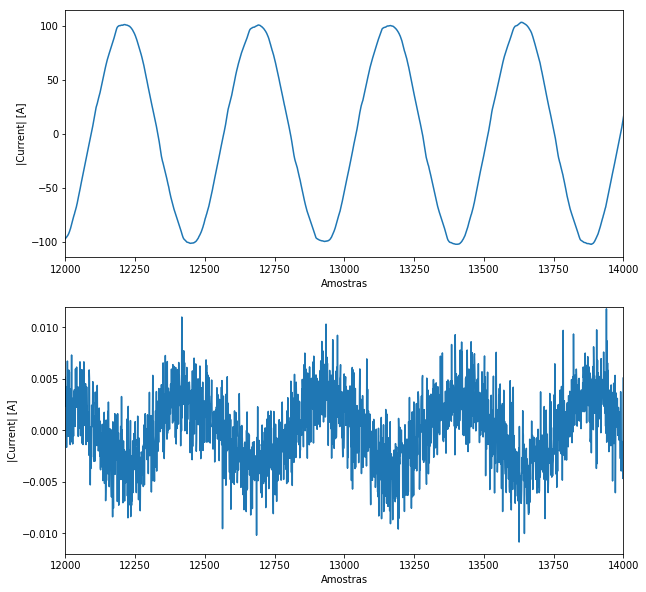

In [9]:
# inverse fft of the Rogowski voltage of a real current
signal_rogowski = fftpack.ifft(polar)

# plot and compare ifft with a real current
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax[1].plot(signal_rogowski)
ax[1].set_ylabel('|Current| [A]')
ax[1].set_xlabel('Amostras')
ax[1].set_xlim(12000, 14000)
ax[1].set_ylim(-0.012, 0.012)

ax[0].plot(data)
ax[0].set_ylabel('|Current| [A]')
ax[0].set_xlabel('Amostras')
ax[0].set_xlim(12000, 14000)

In [11]:
# Exports to wav file the Rogowski voltage of a real current
sampleRate = 10000
wave = 2220000000*(np.real(signal_rogowski[10000: 14000]))
iwave = wave.astype(int)

wavfile.write('ltspice/vRogowski.wav', sampleRate, iwave)

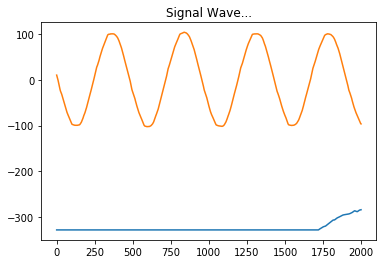

In [12]:
# imports a wav file from a LTspice simulation and compare with de real current signal
wav_data = wavfile.read('ltspice/output.wav', sampleRate)

plt.figure(1)
plt.title('Signal Wave...')
plt.plot(wav_data[1][2000:4000]/100)
plt.plot(data[0:2000])
plt.show()